In [1]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

from tensorflow import keras
print("versão do Keras:", keras.__version__)

# IMPORTANDO COMANDOS E FUNÇÕES #

import numpy as np
import h5py
import matplotlib.pyplot as plt #gerar gráfico
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

import pickle

# IMPORTANDO LAYERS PARA A CNN #

from keras.models import Sequential
from keras import layers
from keras.layers import Dropout

Versão do TensorFlow: 2.1.0
versão do Keras: 2.2.4-tf


Using TensorFlow backend.


In [2]:
# MONTANDO A ESTRUTURA DA CNN #

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5)) # dropout de 50%
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(layers.Flatten()) # camada de achatamento
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(units = 11, activation = 'softmax')) # 11 unidades de saída (11 classes)

In [3]:
print("versao do h5py:", h5py.__version__)

versao do h5py: 2.10.0


In [4]:
model.summary() # resumo da estrutura, com os parâmetros ajustáveis

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)       

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [6]:
from functions_extras import criar_treino_teste

In [7]:
criar_treino_teste('./dataset_fruits/', 0.25)

Criando particionamento
	 492 	+ 164 	= 656 	 -> Apple Granny Smith
	 492 	+ 164 	= 656 	 -> Apple Red 2
	 466 	+ 156 	= 622 	 -> Kiwi
	 492 	+ 164 	= 656 	 -> Limes
	 492 	+ 164 	= 656 	 -> Nectarine
	 438 	+ 146 	= 584 	 -> Onion White
	 492 	+ 164 	= 656 	 -> Peach Flat
	 492 	+ 164 	= 656 	 -> Pear Williams
	 421 	+ 141 	= 562 	 -> Plum 2
	 450 	+ 150 	= 600 	 -> Potato White
	 474 	+ 158 	= 632 	 -> Watermelon
Particionamento criado com sucesso!


In [8]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.35) # comando para reescala

# imagens de treino (65%) 

train_data = datagen.flow_from_directory('dataset_fruits/train',
                                         subset='training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (35%)

valid_data = datagen.flow_from_directory('dataset_fruits/train',
                                         subset='validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 3384 images belonging to 11 classes.
Found 1817 images belonging to 11 classes.


In [9]:
# DEFININDO O COMANDO EARLYSTOPPING #

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 13) #early stopping baseado na melhor acurácia de validação

In [10]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es],
                    verbose=True)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
53/53 [==============================] - 53s 1s/step - loss: 2.2004 - accuracy: 0.1841 - val_loss: 1.9783 - val_accuracy: 0.3682
Epoch 2/100
53/53 [==============================] - 34s 650ms/step - loss: 1.4808 - accuracy: 0.4365 - val_loss: 1.1382 - val_accuracy: 0.8393
Epoch 3/100
53/53 [==============================] - 34s 648ms/step - loss: 1.0134 - accuracy: 0.6167 - val_loss: 0.8504 - val_accuracy: 0.8498
Epoch 4/100
53/53 [==============================] - 34s 647ms/step - loss: 0.7310 - accuracy: 0.7275 - val_loss: 0.3846 - val_accuracy: 0.8949
Epoch 5/100
53/53 [==============================] - 34s 650ms/step - loss: 0.5585 - accuracy: 0.7713 - val_loss: 0.4736 - val_accuracy: 0.8641
Epoch 6/100
53/53 [==============================] - 35s 656ms/step - loss: 0.5238 - accuracy: 0.7923 - val_loss: 0.3191 - val_accuracy: 0.8635
Epoch 7/100
53/53 [==============================] - 35s 661ms/step - loss: 0.5043 - accuracy: 0.8070 - val_loss: 0.1989 - val_accuracy: 0.

In [11]:
model.save('model.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [12]:
model = keras.models.load_model('model.h5')
history = pickle.load(open('trainHistoryDict_model', "rb"))

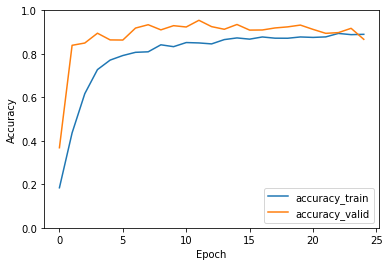

In [13]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

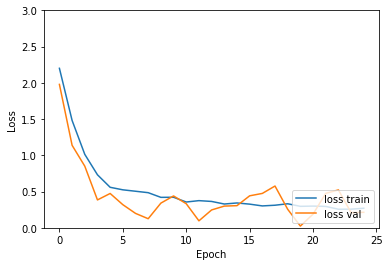

In [14]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [15]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_fruits/test',
                                             target_size = (100, 100),
                                             batch_size = 1,
                                             shuffle=False)

Found 1735 images belonging to 11 classes.


In [16]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model.evaluate(test_data)

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

  ...
    to  
  ['...']
1735/1735 [==============================] - 14s 8ms/step - loss: 0.1781 - accuracy: 0.9504
acurácia nos dados de teste: 0.9504323
loss dos dados de teste: 0.178090739673537


In [17]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1735,)
Accuracy
0.9504322766570605
Balanced Accuracy
0.9500517368810052
Confusion Matrix
[[164   0   0   0   0   0   0   0   0   0   0]
 [  0 142   0   0  22   0   0   0   0   0   0]
 [  0   0 156   0   0   0   0   0   0   0   0]
 [  0   0   0 164   0   0   0   0   0   0   0]
 [  0   0   0   0 164   0   0   0   0   0   0]
 [  0   0   0   0   0 146   0   0   0   0   0]
 [  0   0   0   0   0   0 144   0   0  20   0]
 [  0   0   0   0   0   0   0 164   0   0   0]
 [  0   0   0   0   0   0   0   0 141   0   0]
 [  0   0   0   0   0  44   0   0   0 106   0]
 [  0   0   0   0   0   0   0   0   0   0 158]]
Classification Report


# Primeira estratégia: 100% teste

In [18]:
# MONTANDO A ESTRUTURA DA CNN #

model_1est = keras.models.load_model('model.h5')

In [19]:
model_1est.summary() # resumo da estrutura, com os parâmetros ajustáveis

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)       

In [20]:
criar_treino_teste('./dataset_smkt/', 1)

Criando particionamento
	 200 	+ 1 	= 201 	 -> agata_potato
	 210 	+ 1 	= 211 	 -> diamond_peach
	 211 	+ 1 	= 212 	 -> fuji_apple
	 154 	+ 1 	= 155 	 -> granny_smith_apple
	 170 	+ 1 	= 171 	 -> kiwi
	 246 	+ 1 	= 247 	 -> nectarine
	 74 	+ 1 	= 75 	 -> onion
	 263 	+ 1 	= 264 	 -> plum
	 158 	+ 1 	= 159 	 -> spanish_pear
	 105 	+ 1 	= 106 	 -> taiti_lime
	 191 	+ 1 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [21]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255) # comando para reescala

# imagens de teste (100%) 

test_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         batch_size = 1,
                                         target_size = (100, 100),
                                         shuffle=False) # definindo tamanho das imagens

Found 1982 images belonging to 11 classes.


In [22]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_1est.evaluate(test_data)

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

  ...
    to  
  ['...']
1982/1982 [==============================] - 38s 19ms/step - loss: 11.5916 - accuracy: 0.0989
acurácia nos dados de teste: 0.09889001
loss dos dados de teste: 11.591568201581042


In [23]:
Y_pred = model_1est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1982,)
Accuracy
0.09889001009081735
Balanced Accuracy
0.09109867439068293
Confusion Matrix
[[  0   5   0   0  35   3  46 105   6   0   0]
 [  0   0   0   0   0   2   5 203   0   0   0]
 [  0   0   0   0   5  10  28 164   1   0   3]
 [  0   4   0  23   1   0   0  21   0   0 105]
 [  0   0   0   0   6   0  14  89   0   0  61]
 [  0   0   0   0   0   0  27 219   0   0   0]
 [  0   0   0   0  56   3  14   1   0   0   0]
 [  0   0   0   0   5   0  63 132   0   0  63]
 [  0   0   0   3   1   0   4  78  15   0  57]
 [  0   0   0   0   0   5  27  68   0   0   5]
 [  1   1   0 169   0   1   1  12   0   0   6]]
Classification Report


# Segunda estratégia: 50% treino 50% teste

In [24]:
# Criando modelo

model = keras.models.load_model('model.h5')

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [26]:
criar_treino_teste('./dataset_smkt/', 0.5)

Criando particionamento
	 100 	+ 101 	= 201 	 -> agata_potato
	 105 	+ 106 	= 211 	 -> diamond_peach
	 106 	+ 106 	= 212 	 -> fuji_apple
	 77 	+ 78 	= 155 	 -> granny_smith_apple
	 85 	+ 86 	= 171 	 -> kiwi
	 123 	+ 124 	= 247 	 -> nectarine
	 37 	+ 38 	= 75 	 -> onion
	 132 	+ 132 	= 264 	 -> plum
	 79 	+ 80 	= 159 	 -> spanish_pear
	 53 	+ 53 	= 106 	 -> taiti_lime
	 96 	+ 96 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [27]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.2) # comando para reescala + divisão em 20% para validação

# imagens de treino (80%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (20%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset = 'validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 798 images belonging to 11 classes.
Found 195 images belonging to 11 classes.


In [28]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es],
                    verbose=True)

# informação: steps_per_epoch = número de imagens / batch_size

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/100
13/13 [==============================] - 23s 2s/step - loss: 7.7780 - accuracy: 0.1053 - val_loss: 2.5619 - val_accuracy: 0.1282
Epoch 2/100
13/13 [==============================] - 17s 1s/step - loss: 2.4025 - accuracy: 0.1516 - val_loss: 2.3338 - val_accuracy: 0.1231
Epoch 3/100
13/13 [==============================] - 17s 1s/step - loss: 2.2408 - accuracy: 0.1905 - val_loss: 2.2908 - val_accuracy: 0.1487
Epoch 4/100
13/13 [==============================] - 17s 1s/step - loss: 2.1368 - accuracy: 0.2331 - val_loss: 2.1675 - val_accuracy: 0.2872
Epoch 5/100
13/13 [==============================] - 17s 1s/step - loss: 1.9114 - accuracy: 0.3333 - val_loss: 1.9462 - val_accuracy: 0.3231
Epoch 6/100
13/13 [==============================] - 17s 1s/step - loss: 1.6707 - accuracy: 0.3722 - val_loss: 1.6751 - val_accuracy: 0.4615
Epoch 7/100
13/13 [==============================] - 17s 1s/ste

13/13 [==============================] - 16s 1s/step - loss: 0.2927 - accuracy: 0.8822 - val_loss: 0.7102 - val_accuracy: 0.7385
Epoch 58/100
13/13 [==============================] - 16s 1s/step - loss: 0.2989 - accuracy: 0.8734 - val_loss: 0.8145 - val_accuracy: 0.7128
Epoch 59/100
13/13 [==============================] - 16s 1s/step - loss: 0.2291 - accuracy: 0.9110 - val_loss: 0.8101 - val_accuracy: 0.7026
Epoch 60/100
13/13 [==============================] - 16s 1s/step - loss: 0.2173 - accuracy: 0.8985 - val_loss: 0.8892 - val_accuracy: 0.6462
Epoch 61/100
13/13 [==============================] - 16s 1s/step - loss: 0.2324 - accuracy: 0.9135 - val_loss: 1.1445 - val_accuracy: 0.6821
Epoch 62/100
13/13 [==============================] - 16s 1s/step - loss: 0.2977 - accuracy: 0.8922 - val_loss: 1.2603 - val_accuracy: 0.5949
Epoch 63/100
13/13 [==============================] - 16s 1s/step - loss: 0.3977 - accuracy: 0.8471 - val_loss: 0.6845 - val_accuracy: 0.6872
Epoch 00063: early 

In [29]:
model.save('model_2est.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model_2est', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [30]:
model_2est = keras.models.load_model('model_2est.h5')
history = pickle.load(open('trainHistoryDict_model_2est', "rb"))

In [31]:
model_2est.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)       

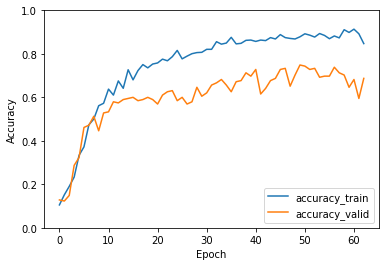

In [32]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

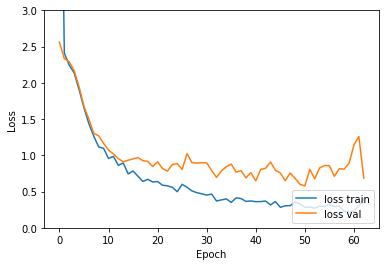

In [33]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [34]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                             target_size = (100, 100),
                                             batch_size = 1,
                                             shuffle=False)

Found 1000 images belonging to 11 classes.


In [35]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_2est.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

  ...
    to  
  ['...']
1000/1000 [==============================] - 17s 17ms/step - loss: 0.4855 - accuracy: 0.8450
acurácia nos dados de teste: 0.845
loss dos dados de teste: 0.485529463907189


In [36]:
Y_pred = model_2est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1000,)
Accuracy
0.845
Balanced Accuracy
0.8453639477820925
Confusion Matrix
[[101   0   0   0   0   0   0   0   0   0   0]
 [  0  55  31   0   0   0   0   0  20   0   0]
 [  0   2  90   0   0   4   0   0  10   0   0]
 [  2   0   0  56   0   0   0   0   0   0  20]
 [ 10   1   0   0  41  23   0   3   8   0   0]
 [  0   0   2   0   1 121   0   0   0   0   0]
 [  2   0   0   0   0   0  36   0   0   0   0]
 [  0   0   1   0   0   3   0 128   0   0   0]
 [  3   1   0   0   0   0   2   0  73   0   1]
 [  0   0   0   0   0   0   0   0   0  51   2]
 [  2   0   0   0   0   0   0   0   1   0  93]]
Classification Report


# Terceira estratégia: 70% treino e 30% teste

In [37]:
# Criando modelo

model = keras.models.load_model('model.h5')

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [39]:
criar_treino_teste('./dataset_smkt/', 0.3)

Criando particionamento
	 140 	+ 61 	= 201 	 -> agata_potato
	 147 	+ 64 	= 211 	 -> diamond_peach
	 148 	+ 64 	= 212 	 -> fuji_apple
	 108 	+ 47 	= 155 	 -> granny_smith_apple
	 119 	+ 52 	= 171 	 -> kiwi
	 172 	+ 75 	= 247 	 -> nectarine
	 52 	+ 23 	= 75 	 -> onion
	 184 	+ 80 	= 264 	 -> plum
	 111 	+ 48 	= 159 	 -> spanish_pear
	 74 	+ 32 	= 106 	 -> taiti_lime
	 134 	+ 58 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [40]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.2) # comando para reescala + divisão em 20% para validação

# imagens de treino (80%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (20%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 1117 images belonging to 11 classes.
Found 272 images belonging to 11 classes.


In [41]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es])

# informação: steps_per_epoch = número de imagens / batch_size

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 5 steps
Epoch 1/100
18/18 [==============================] - 28s 2s/step - loss: 5.4630 - accuracy: 0.1253 - val_loss: 2.4217 - val_accuracy: 0.0809
Epoch 2/100
18/18 [==============================] - 22s 1s/step - loss: 2.2766 - accuracy: 0.1755 - val_loss: 2.3084 - val_accuracy: 0.1250
Epoch 3/100
18/18 [==============================] - 22s 1s/step - loss: 2.0961 - accuracy: 0.2534 - val_loss: 2.1894 - val_accuracy: 0.2022
Epoch 4/100
18/18 [==============================] - 22s 1s/step - loss: 1.8131 - accuracy: 0.3527 - val_loss: 1.9655 - val_accuracy: 0.4228
Epoch 5/100
18/18 [==============================] - 25s 1s/step - loss: 1.5394 - accuracy: 0.4244 - val_loss: 1.7469 - val_accuracy: 0.4118
Epoch 6/100
18/18 [==============================] - 30s 2s/step - loss: 1.2901 - accuracy: 0.5049 - val_loss: 1.6186 - val_accuracy: 0.4816
Epoch 7/100
18/18 [==============================] - 30s 2s/ste

18/18 [==============================] - 22s 1s/step - loss: 0.2279 - accuracy: 0.9078 - val_loss: 0.7646 - val_accuracy: 0.7537
Epoch 58/100
18/18 [==============================] - 22s 1s/step - loss: 0.2110 - accuracy: 0.9239 - val_loss: 0.6761 - val_accuracy: 0.7500
Epoch 59/100
18/18 [==============================] - 21s 1s/step - loss: 0.1958 - accuracy: 0.9123 - val_loss: 0.5882 - val_accuracy: 0.7904
Epoch 60/100
18/18 [==============================] - 22s 1s/step - loss: 0.1833 - accuracy: 0.9257 - val_loss: 0.9150 - val_accuracy: 0.7390
Epoch 61/100
18/18 [==============================] - 22s 1s/step - loss: 0.1505 - accuracy: 0.9409 - val_loss: 0.8181 - val_accuracy: 0.7390
Epoch 62/100
18/18 [==============================] - 22s 1s/step - loss: 0.1901 - accuracy: 0.9221 - val_loss: 0.7530 - val_accuracy: 0.7279
Epoch 63/100
18/18 [==============================] - 22s 1s/step - loss: 0.1906 - accuracy: 0.9167 - val_loss: 0.7614 - val_accuracy: 0.7316
Epoch 64/100
18/18 

In [42]:
model.save('model_3est.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model_3est', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [43]:
model_3est = keras.models.load_model('model_3est.h5')
history = pickle.load(open('trainHistoryDict_model_3est', "rb"))

In [44]:
model_3est.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)       

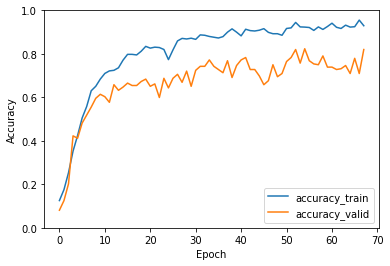

In [45]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

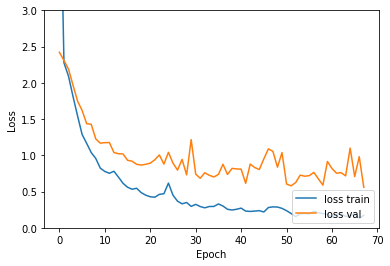

In [46]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [47]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                             target_size = (100, 100),
                                             batch_size = 1,
                                             shuffle=False)

Found 604 images belonging to 11 classes.


In [48]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_3est.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

  ...
    to  
  ['...']
604/604 [==============================] - 7s 12ms/step - loss: 0.1530 - accuracy: 0.9354
acurácia nos dados de teste: 0.93543047
loss dos dados de teste: 0.15297900299767506


In [49]:
Y_pred = model_3est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(604,)
Accuracy
0.9354304635761589
Balanced Accuracy
0.9349305251321106
Confusion Matrix
[[57  0  0  0  0  0  0  0  4  0  0]
 [ 0 51 12  0  0  0  1  0  0  0  0]
 [ 0  0 61  0  0  0  0  0  3  0  0]
 [ 0  0  0 44  0  0  0  0  0  0  3]
 [ 3  0  0  0 42  7  0  0  0  0  0]
 [ 0  0  0  0  0 75  0  0  0  0  0]
 [ 1  0  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0  0]
 [ 2  2  0  0  0  0  0  0 44  0  0]
 [ 0  0  0  0  0  0  0  0  0 32  0]
 [ 1  0  0  0  0  0  0  0  0  0 57]]
Classification Report


# Quarta estratégia: 80% treino e 20% teste

In [50]:
# Criando modelo

model = keras.models.load_model('model.h5')

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [52]:
criar_treino_teste('./dataset_smkt/', 0.2)

Criando particionamento
	 160 	+ 41 	= 201 	 -> agata_potato
	 168 	+ 43 	= 211 	 -> diamond_peach
	 169 	+ 43 	= 212 	 -> fuji_apple
	 124 	+ 31 	= 155 	 -> granny_smith_apple
	 136 	+ 35 	= 171 	 -> kiwi
	 197 	+ 50 	= 247 	 -> nectarine
	 60 	+ 15 	= 75 	 -> onion
	 211 	+ 53 	= 264 	 -> plum
	 127 	+ 32 	= 159 	 -> spanish_pear
	 84 	+ 22 	= 106 	 -> taiti_lime
	 153 	+ 39 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [53]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.2) # comando para reescala + divisão em 20% para validação

# imagens de treino (80%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (20%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 1276 images belonging to 11 classes.
Found 313 images belonging to 11 classes.


In [54]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es])

# informação: steps_per_epoch = número de imagens / batch_size

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 5 steps
Epoch 1/100
20/20 [==============================] - 37s 2s/step - loss: 5.3426 - accuracy: 0.1285 - val_loss: 2.3863 - val_accuracy: 0.0511
Epoch 2/100
20/20 [==============================] - 25s 1s/step - loss: 2.2821 - accuracy: 0.2030 - val_loss: 2.3385 - val_accuracy: 0.0927
Epoch 3/100
20/20 [==============================] - 25s 1s/step - loss: 2.0507 - accuracy: 0.3150 - val_loss: 2.1792 - val_accuracy: 0.2780
Epoch 4/100
20/20 [==============================] - 25s 1s/step - loss: 1.6740 - accuracy: 0.4052 - val_loss: 1.9041 - val_accuracy: 0.3482
Epoch 5/100
20/20 [==============================] - 25s 1s/step - loss: 1.2929 - accuracy: 0.5345 - val_loss: 1.6827 - val_accuracy: 0.3546
Epoch 6/100
20/20 [==============================] - 25s 1s/step - loss: 1.0704 - accuracy: 0.6223 - val_loss: 1.5123 - val_accuracy: 0.4696
Epoch 7/100
20/20 [==============================] - 25s 1s/ste

In [55]:
model.save('model_4est.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model_4est', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [56]:
model_4est = keras.models.load_model('model_4est.h5')
history = pickle.load(open('trainHistoryDict_model_4est', "rb"))

In [57]:
model_4est.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)       

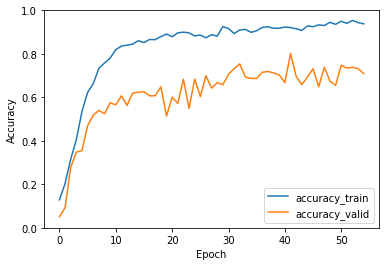

In [58]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

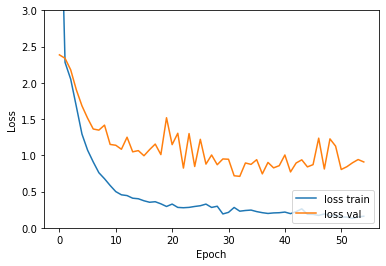

In [59]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [60]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                             target_size = (100, 100),
                                             batch_size = 1,
                                             shuffle=False)

Found 404 images belonging to 11 classes.


In [61]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_4est.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

  ...
    to  
  ['...']
404/404 [==============================] - 7s 17ms/step - loss: 0.1994 - accuracy: 0.9455
acurácia nos dados de teste: 0.94554454
loss dos dados de teste: 0.19938121981757434


In [62]:
Y_pred = model_4est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(404,)
Accuracy
0.9455445544554455
Balanced Accuracy
0.948318631508868
Confusion Matrix
[[36  0  0  0  0  0  0  0  5  0  0]
 [ 0 40  3  0  0  0  0  0  0  0  0]
 [ 0  1 40  0  0  1  0  0  1  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0  0 28  7  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  0  1  0 52  0  0  0]
 [ 0  2  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0]
 [ 1  0  0  0  0  0  0  0  0  0 38]]
Classification Report
